### Low-order SFR Model

"Protection Against Abnormal System Frequency", Chapter 20 of the book: P. M. Anderson, Power System Protection, IEEE Press, New York, 1999.

This is a simple reduced order system frequency response (SFR) model for designing and analyzing load shedding schemes that are part of the underfrequency relay protection of the electrical power system. A frequency decline, due to the sudden loss of generating plants, needs to be arrested before it reaches the critical 57 Hz limit (in a system with the 60 Hz nominal frequency). Hence, a load shedding scheme must first identify the total amount of load that needs to be shed in order to arrest the frequency decline and then define pairs of frequency thresholds and load levels that would result with removing this load from the system. This needs to be carried out immediately after the onset of the frequency drop, where RoCoF and frequency Nadir play an important role. It is recommended to shed half of the total load that needs to be removed at the first step and distribute the reminding half equally among the several additional steps. However, recommendations vary among utilities and local network conditions play an important part in determining the viable load schedding scheme. It should be noted that this model is not valid in a power system with a large share of renewables. This material is intended for classroom use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
linestyles = ['-', '--', '-.', ':',
    (5, (10, 3)),
    (0, (5, 10)),
    (0, (5, 5)),
    (0, (5, 1)),
    (0, (3, 5, 1, 5)),
    (0, (3, 1, 1, 1)),
    (0, (3, 5, 1, 5, 1, 5)),
    (0, (3, 10, 1, 10, 1, 10)),
    (0, (3, 1, 1, 1, 1, 1))
]
colors = plt.cm.Blues_r(np.linspace(0, 0.8, len(linestyles)))

In [3]:
def sfr_model(Pstep, H, D, f=60, R=0.05, Fh=0.3, Tr=8, Km=0.95,
              t_stop=20, dt=0.001):
    """ System Frequency Response model.

    Classical system frequency response (SFR) model,
    from the book: P.M. Anderson, Power System Protection, 
    IEEE Press, New York, 1999, Chapter 20.
    
    Parameters
    ----------
    Pstep : float
        Excess load condition in p.u.
    H : float
        Inertia constant, seconds.
    D : float
        Damping factor in p.u.
    f : float, default=60
        System nominal frequency, Hz.
    R : float, default=0.05
        Governor speed droop of regulation in p.u..
    Fh : float, default=0.3
        Fraction of total power generated by the HP turbine [0.2 - 0.3].
    Tr : float, default=8.0
        Reheat time constant, seconds.
    Km : float, default=0.95
        Mechanical power gain factor in p.u.
    t_stop : float, default=10
        Total time of frequency response simulation, seconds.
    dt : float, default=0.001
        Time step of the simulation, seconds.
    
    Returns
    -------
    t : array
        Time in seconds.
    d_omega : array
        Deviation in respect to the nominal frequency.
    rocof : float
        Rate of Change of Frequency (RoCoF) in Hz/s.
    nadir : float
        Frequency Nadir in Hz.
    tz : float
        Time of the frequency Nadir in seconds.
    
    Notes
    -----
    The model is based on the assumption that the power system
    is dominated by large termal power plants and that it can
    be described by a single representative (equivalent) unit.
    This is not the case with power systems with large shares
    of renewable power plants (i.e. wind and solar).
    """
    omega_n = np.sqrt((D*R + Km) / (2*H*R*Tr))
    zeta = omega_n * ((2*H*R + (D*R + Km*Fh)*Tr) / (2*(D*R + Km)))
    
    # Time range for the simulation.
    t = np.arange(start=0, stop=t_stop, step=dt)  # (seconds)

    d_omega = np.empty_like(t)
    if zeta <= 1:
        # Underdamped case.
        a = np.sqrt((1. - 2*Tr*zeta*omega_n + Tr**2*omega_n**2) / (1. - zeta**2))
        omega_r = omega_n * np.sqrt(1. - zeta**2)
        phi1 = np.arctan((omega_r*Tr) / (1. - zeta*omega_n*Tr))
        phi2 = np.arctan(np.sqrt(1. - zeta**2) / (-zeta))
        phi = phi1 - phi2
        K = (R*Pstep) / (D*R + Km)
        # Deviation in respect to the nominal frequency.
        for i in range(len(t)):
            d_omega[i] = K*f * (1. + a*np.exp(-zeta*omega_n*t[i]) * np.sin(omega_r*t[i] + phi))  # Hz
        # RoCoF
        rocof = ((a*R*omega_n*Pstep) / (D*R + Km)) * np.sin(phi1) * f
        # Frequency Nadir
        tz = np.arctan((omega_r*Tr) / (zeta*omega_n*Tr - 1.)) / omega_r  # seconds
        tiz = np.argwhere(t <= tz)
        if tiz.size != 0:
            ti = tiz[-1][0]
        else:
            raise ValueError(f'Invalid argwhere condition: {tiz}')
        nadir = f + d_omega[ti]  # Hz
    else:
        raise NotImplementedError('Overdamped case is not implemented!')
    
    return t, d_omega, rocof, nadir, tz
    

In [4]:
# Input system data (per unit on the MVA base of the system):
f = 60     # system nominal frequency (Hz)
R = 0.06   # speed droop of regulation
Fh = 0.3   # fraction of total power generated by the HP turbine [0.2 - 0.3]
H = 3.5    # inertia constant (seconds)
Tr = 8.0   # reheat time constant (seconds)
Km = 0.95  # mechanical power gain factor
D = 1.0    # damping factor

#### Effect of Disturbance Size

In [5]:
# Step response to load increase (p.u.).
Pstep = np.arange(start=-0.1, stop=-1, step=-0.1)

In [6]:
# Frequency response characteristic (SFR model).
sfr = []
RoCoF = []
f_min = []
t_stop, dt = 20, 0.001
t = np.arange(start=0, stop=t_stop, step=dt)  # time (s)
# Analyze system response to different load increase cases.
for j, P in enumerate(Pstep):
    _, d_omega, rocof, nadir, tz = sfr_model(P, H, D, f, R, Fh, Tr, Km, 
                                            t_stop=t_stop, dt=dt)
    sfr.append(d_omega)
    RoCoF.append(rocof)
    f_min.append(nadir)

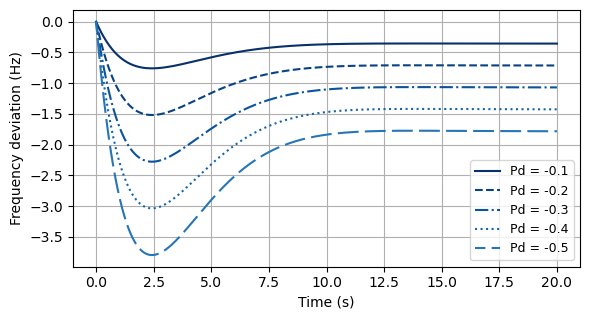

In [7]:
fig, ax = plt.subplots(figsize=(6, 3.3))
for j, P in enumerate(Pstep):
    if j < 5:
        ax.plot(t, sfr[j], ls=linestyles[j], lw=1.5, c=colors[j], label=f'Pd = {P:.1f}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency deviation (Hz)')
ax.grid(which='major', axis='both')
ax.legend(loc='lower right', fontsize=9)
fig.tight_layout()
plt.show()

In [8]:
# RoCoF & Frequency Nadir.
print(f'Time of the frequency Nadir: {tz:.3f} (s)')
for rocof, nadir, P in zip(RoCoF, f_min, Pstep):
    print(f'Pstep = {P:.1f} (pu): RoCoF = {rocof:.3f} (Hz/s) and f_min = {nadir:.3f} (Hz)')

Time of the frequency Nadir: 2.426 (s)
Pstep = -0.1 (pu): RoCoF = 0.857 (Hz/s) and f_min = 59.241 (Hz)
Pstep = -0.2 (pu): RoCoF = 1.714 (Hz/s) and f_min = 58.482 (Hz)
Pstep = -0.3 (pu): RoCoF = 2.571 (Hz/s) and f_min = 57.723 (Hz)
Pstep = -0.4 (pu): RoCoF = 3.429 (Hz/s) and f_min = 56.965 (Hz)
Pstep = -0.5 (pu): RoCoF = 4.286 (Hz/s) and f_min = 56.206 (Hz)
Pstep = -0.6 (pu): RoCoF = 5.143 (Hz/s) and f_min = 55.447 (Hz)
Pstep = -0.7 (pu): RoCoF = 6.000 (Hz/s) and f_min = 54.688 (Hz)
Pstep = -0.8 (pu): RoCoF = 6.857 (Hz/s) and f_min = 53.929 (Hz)
Pstep = -0.9 (pu): RoCoF = 7.714 (Hz/s) and f_min = 53.170 (Hz)


#### Effect of Inertia

In [9]:
inertia_values = np.arange(start=3, stop=5.5, step=0.5)
sfr_inert = []
for H in inertia_values:
    t, d_omega, *kw = sfr_model(-0.2, H=H, D=1.)
    sfr_inert.append(d_omega)

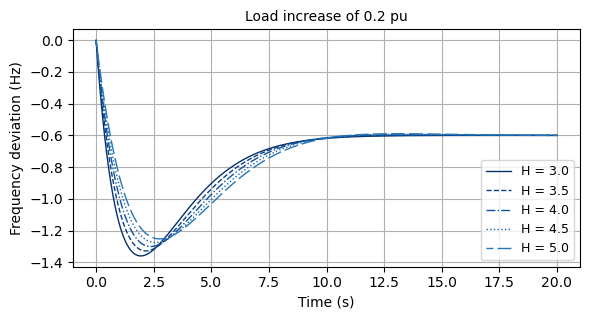

In [10]:
fig, ax = plt.subplots(figsize=(6, 3.3))
ax.set_title('Load increase of 0.2 pu', fontsize=10)
for j, H in enumerate(inertia_values):
    ax.plot(t, sfr_inert[j], ls=linestyles[j], lw=1, c=colors[j], label=f'H = {H:.1f}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency deviation (Hz)')
ax.grid(which='major', axis='both')
ax.legend(loc='lower right', fontsize=9)
fig.tight_layout()
plt.show()

#### Effect of Damping

In [11]:
damping = np.arange(start=0, stop=2.5, step=0.5)
sfr_damp = []
for D in damping:
    t, d_omega, *kw = sfr_model(-0.2, D=D, H=4.)
    sfr_damp.append(d_omega)

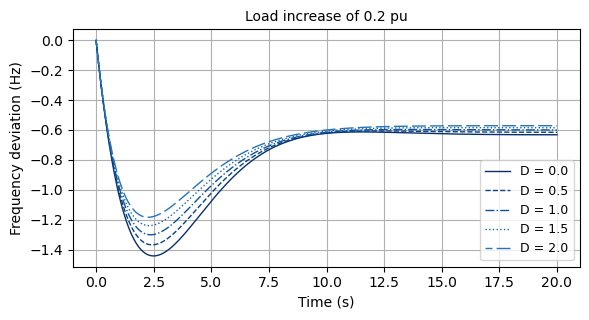

In [12]:
fig, ax = plt.subplots(figsize=(6, 3.3))
ax.set_title('Load increase of 0.2 pu', fontsize=10)
for j, D in enumerate(damping):
    ax.plot(t, sfr_damp[j], ls=linestyles[j], lw=1, c=colors[j], label=f'D = {D:.1f}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency deviation (Hz)')
ax.grid(which='major', axis='both')
ax.legend(loc='lower right', fontsize=9)
fig.tight_layout()
plt.show()

### Load shedding

In [13]:
# Select the load increase case from the list of treated cases,
# by identifying the relevant case index number from 0 (0.1 pu)
# to 8 (0.9 pu).
load_index = 5  # EDIT HERE

In [14]:
# Define load shedding scheme(s).
scheme1 = {# Four equal steps (0.25 pu).
    0: (59.5, 0.0625),  # (Hz, pu)
    1: (59.2, 0.0625),
    2: (58.9, 0.0625),
    3: (58.6, 0.0625),
}
scheme2 = {# Six unequal steps (0.25 pu).
    0: (59.5, 0.048),
    1: (59.3, 0.048),
    2: (59.1, 0.042),
    3: (58.8, 0.040),
    4: (58.5, 0.036),
    5: (58.2, 0.032),
}
scheme3 = {# Four equal steps (0.32 pu).
    0: (59.5, 0.08),
    1: (59.2, 0.08),
    2: (58.9, 0.08),
    3: (58.6, 0.08),
}
scheme4 = {# UCTE recommended two unequal steps.
    0: (59.0, 0.15),  # 10-15 %
    1: (58.7, 0.20),  # 15-20 %
}
# Select schemes for the comparative analysis.
list_of_schemes = [
    (scheme1, '4 equal steps (0.25 pu)'), 
    (scheme2, '6 unequal steps (0.25))'),
    (scheme3, '4 equal steps (0.32 pu)'),
    (scheme4, 'UCTE scheme (0.35 pu)')
]

In [15]:
t_stop, dt = 20, 0.001
t = np.arange(start=0, stop=t_stop, step=dt)  # time (s)

In [16]:
# Intermediate constants.
omega_n = np.sqrt((D*R + Km) / (2*H*R*Tr))
zeta = omega_n * ((2*H*R + (D*R + Km*Fh)*Tr) / (2*(D*R + Km)))
omega_r = omega_n * np.sqrt(1. - zeta**2)
phi1 = np.arctan((omega_r*Tr) / (1. - zeta*omega_n*Tr))
phi2 = np.arctan(np.sqrt(1. - zeta**2) / (-zeta))
phi = phi1 - phi2
a = np.sqrt((1. - 2*Tr*zeta*omega_n + Tr**2*omega_n**2) / (1. - zeta**2))

In [17]:
# Analyze and compare different load shedding schemes.
shed_curves = []
for (scheme, _) in list_of_schemes:
    P = Pstep[load_index]
    eps = 0.01
    load_shed = 0
    d_omega_shed = np.empty_like(t)
    for i in range(len(t)):
        K = (R*P) / (D*R + Km)
        # Deviation in respect to the nominal frequency.
        d_omega_shed[i] = K*f * (1. + a*np.exp(-zeta*omega_n*t[i]) * np.sin(omega_r*t[i] + phi))  # Hz
        for key, value in scheme.items():
            if key == load_shed:
                freq, load = value[0], value[1]
                if abs((f+d_omega_shed[i]) - freq) <= eps:
                    P += load
                    load_shed += 1
                    break
    shed_curves.append(d_omega_shed)

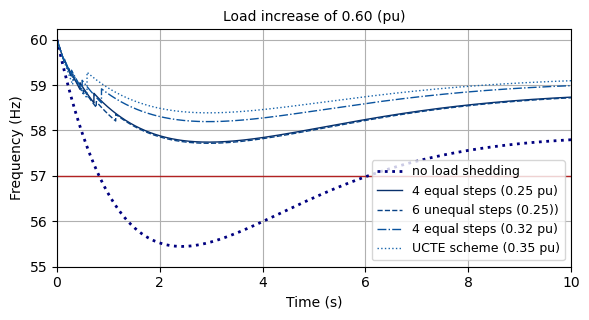

In [18]:
fig, ax = plt.subplots(figsize=(6, 3.3))
ax.set_title(f'Load increase of {abs(Pstep[load_index]):.2f} (pu)', fontsize=10)
ax.axhline(57, ls='-', lw=1, c='firebrick')  # critical frequency limit
ax.plot(t, f+sfr[load_index], ls=':', lw=2, c='navy', label='no load shedding')
# Plot SFR curves for different load shedding schemes.
for i, (_, name) in enumerate(list_of_schemes):
    ax.plot(t, f+shed_curves[i], ls=linestyles[i], lw=1, c=colors[i], label=name)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.grid(which='major', axis='both')
ax.legend(loc='lower right', fontsize=9)
ax.set_xlim(0, 10)
ax.set_ylim(bottom=55)
fig.tight_layout()
plt.show()